<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br><b>Prototype Target Dashboard</b> <br>
Contact author: Douglas Tucker <br>
Last verified to run: 2024-08-07 <br>
LSST Science Pipelines version: Weekly 2024_16 <br>
Container size: medium <br>

**Description:** A prototype dashboard for exploring targets (and science programs) for a given night.  This initial version focuses on AuxTel observations, but should be useful for ComCom and LSSTcam commissioning, when there will be a greater diversity of observational programs than those provided by the survey scheduler during standard operations.

See Jira issue <a href=https://rubinobs.atlassian.net/browse/PREOPS-5002>PREOPS-5002</a>.

**Credit:** Based heavily on the <a href=https://github.com/sylvielsstfr/AuxTelComm/blob/main/notebooks_usdf/ana_auxtelprod_jn/spectractor_v3.1.0_May2024/ListOfExposures-hologram-oga.ipynb> List of Exposures at USDF in OGA</a> notebook by Sylvie Dagoret-Campagne.  This initial "Prototype Target Dashboard" notebook would not have been possible without it.

## 1. Introduction

### 1.0 User Input

Define repo, collection, instrument, and day of observation to study:

In [1]:
## LATISS data from April 2024:
##repo = "/sdf/group/rubin/repo/main"
##repo="/sdf/group/rubin/repo/oga/"
##collection='LATISS/raw/all'
##instrument = 'LATISS'
##day_obs = 20240422

## Ops Rehearsal 3, "Intermittent Cumulative DRP: of the 3 nights of ops rehearsal 3 data
##  (https://confluence.lsstcorp.org/display/DM/Campaigns)
#repo = "/repo/embargo"
#collection='LSSTComCamSim/quickLook/24'
#instrument = 'LSSTComCamSim'
#day_obs = 20240404

# Ops Rehearsal 4 intra-night
#  (https://confluence.lsstcorp.org/display/DM/Campaigns)
repo = "embargo_or4"
collection = 'LSSTComCamSim/nightlyValidation/0'
instrument = 'LSSTComCamSim'
day_obs = 20240625

# The intra-night collection does not seem to have a skymap; 
#  so we will use the 10am collection to grab the skymap
lsst_distrib_tag = "w_2024_25"
collection_sky = """LSSTComCamSim/runs/nightlyValidation/%d/%s/DM-44966""" % (day_obs, lsst_distrib_tag)
skymap_name = 'ops_rehersal_prep_2k_v1'


Define columns to groupby and plot against each other:

In [2]:
col_sciprog = 'science_program'
#col_target = 'target'
#col_target = 'HPX8'  # HPX8 is used as a proxy for target_name or block
col_target = 'field_name'  # field_name is used as a proxy for target_name or block
col_filter = 'filter'
col_id = 'id'

### 1.1 Import Packages

In [3]:
import sys
import os
import io
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import healpy as hp
from matplotlib.colors import LogNorm
from IPython.display import display, HTML
import lsst.afw.display as afwDisplay
import lsst.daf.butler as dafButler
import lsst.geom as geom

from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.ticker
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

from astropy.io import fits
from astropy.time import Time

import warnings

### 1.2. Define functions and parameters

Create a function to create a pandas DataFrame, df_grouped, that contains the results of performing a 2D groupby operation on a pandas DataFrame, df, and counts the number of entries in the col_count column for each (col_x, col_y).  One can choose to include a count of zero for cases where (col_x, col_y) have no entries in col_count (the default), or to exclude those cases.  The resulting pandas DataFrame, df_grouped, is also sorted by (col_x, col_y).

In [4]:
# Thanks to the ChatGPT on Poe.com and to https://stackoverflow.com/questions/37003100/pandas-groupby-for-zero-values for help in creating this function!

def df2Dgroupby(df, col_x, col_y, col_count, fill_zeros=True):

    if fill_zeros==True:

        df_grouped = (
            df_science.groupby([col_x, col_y])[col_count]
            .count()
            .unstack(fill_value=0)
            .stack()
            .reset_index()
            .rename(columns={0: "number"})
            .sort_values([col_x, col_y])
        )

    else:

        df_grouped = (
            df_science.groupby([col_x, col_y])[col_count]
            .count()
            .reset_index()
            .rename(columns={col_count: "number"})
            .sort_values([col_x, col_y])
        )
        
    return df_grouped

The same, but for performing the `groupby` over 3 columns:  

In [5]:
# Thanks to the ChatGPT on Poe.com and to https://stackoverflow.com/questions/37003100/pandas-groupby-for-zero-values for help in creating this function!

def df3Dgroupby(df, col_x, col_y, col_z, col_count, fill_zeros=True):

    if fill_zeros==True:

        df_grouped = (
            df_science.groupby([col_x, col_y, col_z])[col_count]
            .count()
            .unstack(fill_value=0)
            .stack()
            .reset_index()
            .rename(columns={0: "number"})
            .sort_values([col_x, col_y, col_z])
        )

    else:

        df_grouped = (
            df_science.groupby([col_x, col_y, col_z])[col_count]
            .count()
            .reset_index()
            .rename(columns={col_count: "number"})
            .sort_values([col_x, col_y, col_z])
        )
        
    return df_grouped

Create a function to plot an annotated headmap for a pandas DataFrame created by the above `df2Dgroupby` function:

In [6]:
# With a little help from https://seaborn.pydata.org/generated/seaborn.heatmap.html ...

def plotAnnotatedHeatMap_df2Dgroupby(df_grouped, col_index, col_column, col_values, title='Annotated Heatmap', cmap='Blues'):

    # Estimate a good figure size in x,y for the resulting plot...
    figsize_x = df_grouped[col_column].unique().size
    figsize_y = df_grouped[col_index].unique().size
    if figsize_y < 3:
        figsize_y = 1
    else:
        figsize_y = round(figsize_y/3)
    
    # Pivot the DataFrame to works with Seaborn heatmap...
    pivot_table = df_grouped.pivot(index=col_index, columns=col_column, values=col_values)
    fig, ax = plt.subplots(figsize=(figsize_x, figsize_y))
    #fig, ax = plt.subplots(figsize=(5, 15))
    #fig, ax = plt.subplots()

    # Plot the annoated heatmap...
    sns.heatmap(pivot_table, annot=True, cmap=cmap, linecolor='Black', linewidths=0.1, ax=ax)

    # Add labels and title and rotate the x tick labels by 90 degrees...
    ax.set_xlabel(col_column)
    ax.set_ylabel(col_index)
    ax.set_title(title)
    plt.xticks(rotation=90)

Create a function to perform a many-to-one match based on RA, DEC sky coordinates:

In [7]:
# Kudos to Claude-3.5-Sonnet AI from Poe.com fro this function!

def skyMatchCatManytoOne(df_a, df_a_ra_colname, df_a_dec_colname, df_b, df_b_ra_colname, df_b_dec_colname, max_sep_deg):

    from astropy.coordinates import SkyCoord # High-level coordinates
    from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
    from astropy.coordinates import Angle, Latitude, Longitude  # Angles
    from astropy import units as u
    from astropy.coordinates.matching import search_around_sky
    import numpy as np
    import pandas as pd

    # Create SkyCoord objects for both DataFrames
    coords_a = SkyCoord(ra=df_a[df_a_ra_colname].values*u.degree, dec=df_a[df_a_dec_colname].values*u.degree)
    coords_b = SkyCoord(ra=df_b[df_b_ra_colname].values*u.degree, dec=df_b[df_b_dec_colname].values*u.degree)

    # Set a maximum separation for matching (adjust as needed)
    max_sep_deg = max_sep_deg * u.degree

    # Perform the search
    idx_a, idx_b, d2d, _ = search_around_sky(coords_a, coords_b, max_sep_deg)

    # Create a DataFrame with the matches
    df_matches = pd.DataFrame({
        'idx_a': idx_a,
        'idx_b': idx_b,
        'separation': d2d.degree
    })

    # Group by idx_a and find the minimum separation for each
    best_matches = df_matches.loc[df_matches.groupby('idx_a')['separation'].idxmin()]

    # Create the final matched DataFrame, keeping all entries from df_a
    df_matched = df_a.copy()

    # Prepare the data from df_b to be joined
    df_b_matched = df_b.iloc[best_matches['idx_b']].copy()
    df_b_matched['idx_a'] = best_matches['idx_a'].values
    df_b_matched['separation'] = best_matches['separation'].values
    df_b_matched = df_b_matched.set_index('idx_a')

    # Perform the left join
    df_matched = df_matched.join(df_b_matched, rsuffix='_b')
    
    # Reset index if needed
    df_matched = df_matched.reset_index(drop=True)

    # Fill NaN values in the 'separation' column with a sentinel value (e.g., -1) to indicate no match
    df_matched['separation'] = df_matched['separation'].fillna(-1)

    # Optionally, you can add a boolean column to easily identify matched and unmatched rows
    df_matched['has_match'] = df_matched['separation'] != -1

    # Print some statistics
    print(f"Total entries in df_a: {len(df_a)}")
    print(f"Entries in df_a with matches: {df_matched['has_match'].sum()}")
    print(f"Entries in df_a without matches: {(~df_matched['has_match']).sum()}")

    return df_matched

Define some healpix tools <span style="color:red; font-weight:bold">(Maybe no longer necessary?)</span>:

In [8]:
# Thanks to Sahar Allam and Alex Drlica-Wagner!

##################################
def radec2thetaphi(ra, dec):
    import numpy as np
    return (90-dec)*np.pi/180., ra*np.pi/180.

##################################
#DESDM uses nside=128, nest=True
#Alex Drlica Wagner's healpixelated Gaia DR2 on des40 uses nside=32, nest=False
def getipix(nside,ra,dec,nest=True):
    import healpy as hp
    theta, phi = radec2thetaphi(ra, dec)
    ipix = hp.pixelfunc.ang2pix(nside, theta, phi, nest)
    return ipix

##################################

Define a function to return the tract id, given the ra, dec and a skymap:

In [9]:
def find_tract(ra,dec,skymap):

    import lsst.geom as geom
    
    try:
        sky_point = geom.SpherePoint(ra * geom.degrees,
                                     dec * geom.degrees)

        tract = skymap.findTract(sky_point)
        tract = tract.tract_id
    
        del sky_point

    except:
        
        tract = -1
    
    return tract

Define a class to stop "Run All" at a code cell containing the command "raise StopExecution":

In [10]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

Set filter warnings to "ignore" to avoid a lot of "logorrhea" to the screen:

In [11]:
warnings.filterwarnings("ignore")

Set default backend for afwDisplay to `matplotlib`:

In [12]:
afwDisplay.setDefaultBackend('matplotlib')

Set a few parameters to use later, when plotting:

In [13]:
plt.style.use('tableau-colorblind10')

plot_filter_labels = ['u', 'g', 'r', 'i', 'z', 'y']
plot_filter_colors = {'u': '#56b4e9', 'g': '#008060', 'r': '#ff4000',
                      'i': '#850000', 'z': '#6600cc', 'y': '#000000'}
plot_filter_symbols = {'u': 'o', 'g': '^', 'r': 'v', 'i': 's', 'z': '*', 'y': 'p'}

This is a temporary fix to attach field names to the Ops Rehearsal 4 science exposures:

In [14]:
# Table of Ops Rehearsal 4 Fields from https://confluence.lsstcorp.org/pages/viewpage.action?pageId=259785406
ascii_table = """
Field                       RA          DEC     stellarDens     E_BV
Rubin_SV_095_-25           95.00      -25.00        2.92        0.05
Rubin_SV_125_-15          125.00      -15.00        3.78        0.06
DESI_SV3_R1               179.60        0.00        0.53        0.03
Rubin_SV_225_-40          225.00      -40.00       12.67        0.08
DEEP_A0                   216.00      -12.50        1.17        0.09
Rubin_SV_250_2            250.00        2.00        4.56        0.07
Rubin_SV_300_-41          300.00      -41.00        5.22        0.09
Rubin_SV_280_-48          280.00      -48.00       17.64        0.07
DEEP_B0                   310.00      -19.00        3.28        0.04
ELAIS_S1                    9.45      -44.00        0.56        0.01
XMM_LSS                    35.71       -4.75        0.47        0.03
ECDFS                      53.12      -28.10        0.61        0.01
COSMOS                    150.10        2.18        0.67        0.02
EDFS_A                     58.90      -49.31        0.75        0.01
EDFS_B                     63.60      -47.60        0.81        0.01"""

# Convert the string to a file-like object
ascii_io = io.StringIO(ascii_table)

# Read the ASCII table into a pandas DataFrame
df_field = pd.read_csv(ascii_io, delim_whitespace=True)

## Display df_field
#df_field

Add two healpix columns to this table, one *very* roughly the area of a ComCam field-of-view (NSIDE=2^6=64 --> 0.84 sq deg) and one *very* roughly the area of an LSSTCam field-of-view (NSIDE=2^4=16 --> 13 sq deg) <span style="color:red; font-weight:bold">(Maybe no longer necessary?)</span>:

In [15]:
# Add healpix info
df_field.loc[:,'HPX64'] = getipix(64, df_field.loc[:,'RA'].values, df_field.loc[:,'DEC'].values)
df_field.loc[:,'HPX16'] = getipix(16, df_field.loc[:,'RA'].values, df_field.loc[:,'DEC'].values)

## Display df_field
#df_field

## 2. Access data for this repo, collection, and day of observation

### 2.1 Instantiate butler and create registry

In [16]:
butler = dafButler.Butler(repo, collections=collection)
registry = butler.registry

### 2.2 Read in information from the `exposure` dimension and create pandas DataFrame

Query the metadata for the `exposure` dimension, limiting the results to this particular instrument and day of observation:

In [17]:
query="instrument='%s' AND day_obs=%d" % (instrument, day_obs)
results = registry.queryDimensionRecords('exposure',where=query)

Stop executing if there are no results returned:

In [18]:
n_results = results.count()

if n_results <= 0:
    raise StopExecution
else:
    print("There are %d results returned." % n_results)

There are 862 results returned.


Instantiate a pandas `DataFrame` with useful columns available in the `exposure` dimension:

In [19]:
df_exposure = pd.DataFrame(columns=['id', 'obs_id','day_obs', 'seq_num',
                                    'time_start','time_end' ,'type', 'reason', 
                                    'target','filter','zenith_angle',
                                    'expos','ra','dec','skyangle',
                                    'azimuth','zenith','science_program',
                                    'jd','mjd'])

Read the query results into the new pandas `DataFrame`:

In [20]:
for count, info in enumerate(results):
    
    
    try:
        df_exposure.loc[count] = [info.id, info.obs_id, info.day_obs, info.seq_num, 
                                  pd.to_datetime(info.timespan.begin.to_string()),
                                  pd.to_datetime(info.timespan.end.to_string()),
                                  info.observation_type, info.observation_reason, info.target_name, 
                                  info.physical_filter, info.zenith_angle, 
                                  info.exposure_time,info.tracking_ra, info.tracking_dec, 
                                  info.sky_angle,info.azimuth ,info.zenith_angle, 
                                  info.science_program, info.timespan.begin.jd,info.timespan.begin.mjd ]
    except:
        print(">>>   Unexpected error:", sys.exc_info()[0])
        info_timespan_begin_to_string = "2021-01-01 00:00:00.00"
        info_timespan_end_to_string = "2051-01-01 00:00:00.00"
        info_timespan_begin_jd = 0
        info_timespan_begin_mjd = 0
        df_exposure.loc[count] = [info.id, info.obs_id, info.day_obs, info.seq_num, 
                                  pd.to_datetime(info_timespan_begin_to_string),
                                  pd.to_datetime(info_timespan_end_to_string), 
                                  info.observation_type, info.observation_reason, info.target_name, 
                                  info.physical_filter, info.zenith_angle, 
                                  info.exposure_time,info.tracking_ra, info.tracking_dec, 
                                  info.sky_angle,info.azimuth ,info.zenith_angle, 
                                  info.science_program, info_timespan_begin_jd, info_timespan_begin_mjd ]
 
    


Re-cast the `id`, `day_obs`, and `seq_num` rows as `int`'s:

In [21]:
df_exposure = df_exposure.astype({"id": int,'day_obs': int,'seq_num':int})

Replace `NaN`'s in the `ra` and `dec` columns with zero.  (`NaN`'s in `ra`, `dec` wreak havoc for the healpix tools defined in Section 1.2 above.) <span style="color:red; font-weight:bold">(Maybe no longer necessary?)</span>

In [22]:
df_exposure['ra'] = df_exposure['ra'].fillna(0)
df_exposure['dec'] = df_exposure['dec'].fillna(0)

Add healpix info <span style="color:red; font-weight:bold">(Maybe no longer necessary?):

In [23]:
df_exposure.loc[:,'HPX64'] = getipix(64, df_exposure.loc[:,'ra'].values, df_exposure.loc[:,'dec'].values)
df_exposure.loc[:,'HPX16'] = getipix(16, df_exposure.loc[:,'ra'].values, df_exposure.loc[:,'dec'].values)

To add the field_name to df_exposure, perform a left join of df_field on df_exposure <span style="color:red; font-weight:bold">(Note use of HPX16, but maybe that part is no longer necessary?)</span>:

In [24]:
# First, perform the merge...
# (Before we had the table of fields, we matched by HPX16 value.)
#df_merged = df_exposure.merge(df_field, on='HPX16', how='left', suffixes=('', '_fld'))
df_merged = skyMatchCatManytoOne(df_exposure, 'ra', 'dec', df_field, 'RA', 'DEC', 3.)

# Next, define a function to fill NaN values in 'Field' with 'HPX16' for unmatched exposures
def fill_field(row):
    if pd.isna(row['Field']):
        return 'HPX16_'+str(row['HPX16'])  # Convert to string if you want 'Field' to be string type
    return row['Field']

# Apply the function to fill NaN values
df_merged['Field'] = df_merged.apply(fill_field, axis=1)

# Remove extraneous columns from df_merged
#df_merged = df_merged.drop(['RA', 'DEC', 'stellarDens', 'E_BV', 'HPX64_fld', 'HPX16_fld'], axis=1)
df_merged = df_merged.drop(['RA', 'DEC', 'stellarDens', 'E_BV', 'HPX64_b', 'HPX16_b'], axis=1)

# Rename 'Field' column to 'field_name'
df_merged = df_merged.rename(columns={'Field': 'field_name'})

# Rename df_merged to df_exposure
df_exposure = df_merged

## Display updated df_exposure
#df_exposure

Total entries in df_a: 862
Entries in df_a with matches: 733
Entries in df_a without matches: 129


Add the tract id as a column in df_exposure.  First, access the skymap, then add the tract to the df_exposure DataFrame:

In [25]:
butler_sky = dafButler.Butler(repo, collections=collection_sky)
registry_sky = butler_sky.registry
skymap = butler_sky.get('skyMap', skymap=skymap_name)
df_exposure['tract'] = df_exposure.apply(lambda row: find_tract(row['ra'], row['dec'], skymap), axis=1)

Create a `DataFrame` containing just the science exposures:

In [26]:
df_science = df_exposure[df_exposure.type == 'science']

## 3. Analyse results of the exposure query

For the rest of the notebook, we do not want to restrict the the number of rows displayed for
pandas tabular information.  Therefore, let us turn off the pandas maximum rows setting.  We will turn it back on at the end of the notebook.

In [27]:
# Change the display.max_rows option
pd.set_option("display.max_rows", None)

### 3.1 Tract and Field

Display table showing which tracts are associated with which field, sorted by field name:

In [28]:
df_science[[col_target,'tract']].drop_duplicates().sort_values([col_target, 'tract']).reset_index(drop=True)

,field_name,tract
0,DEEP_A0,7445
1,DEEP_B0,6568
2,ELAIS_S1,2877
3,Rubin_SV_225_-40,3346
4,Rubin_SV_225_-40,3533
5,Rubin_SV_250_2,9880
6,Rubin_SV_280_-48,2494
7,Rubin_SV_280_-48,2495
8,Rubin_SV_300_-41,3384


Display table showing which fields are associated with which tract, sorted by tract number:

In [29]:
df_science[['tract',col_target,]].drop_duplicates().sort_values(['tract', col_target]).reset_index(drop=True)

,tract,field_name
0,2494,Rubin_SV_280_-48
1,2495,Rubin_SV_280_-48
2,2877,ELAIS_S1
3,3346,Rubin_SV_225_-40
4,3384,Rubin_SV_300_-41
5,3533,Rubin_SV_225_-40
6,6568,DEEP_B0
7,7445,DEEP_A0
8,9880,Rubin_SV_250_2


### 3.2 Counts

#### 3.2.1 General

Tabulate the counts of different types of exposures taken on this date:

In [30]:
#df_exposure.groupby("type").count()["id"]
df_exposure.groupby("type").count()["id"].reset_index().rename(columns={'id': 'Number'})

,type,Number
0,acq,23
1,bias,11
2,cwfs,46
3,dark,11
4,flat,11
5,focus,27
6,science,733


#### 3.2.2 Science Program

Tabulate exposures for the different science programs run on this date:

In [31]:
#df_science.groupby(col_sciprog).count()[col_id]
df_science.groupby(col_sciprog).count()[col_id].reset_index().rename(columns={'id': 'Number'})

,science_program,Number
0,BLOCK-297,733


Plot as a 1D histogram:

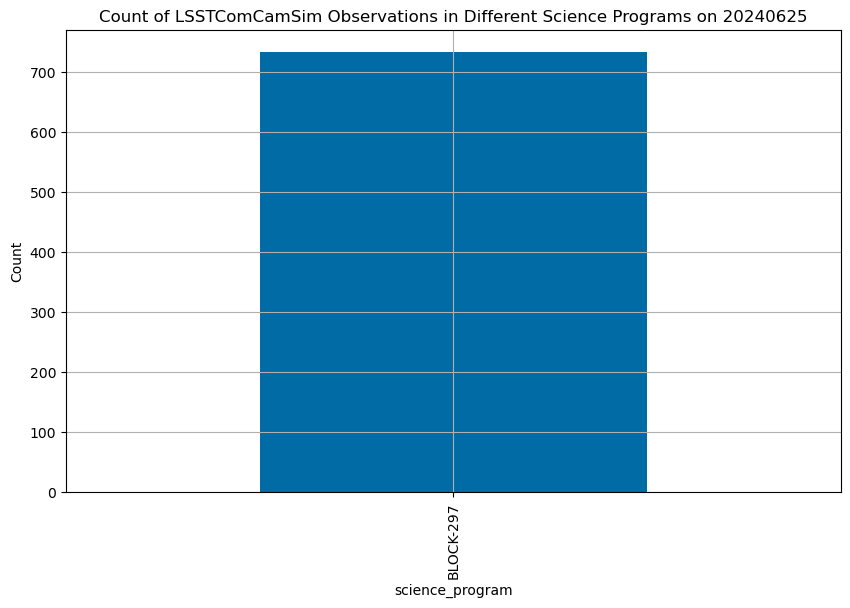

In [32]:
plt.figure(figsize=(10, 6))

# Count the occurrences of each unique value in col1
value_counts = df_science[col_sciprog].value_counts()

# Create the bar plot
value_counts.plot(kind='bar')

# Add labels and title
plt.xlabel(col_sciprog)
plt.ylabel('Count')
title = "Count of %s Observations in Different Science Programs on %s" % (instrument, day_obs)
plt.title(title)
plt.grid(True)


#### 3.2.3 Targets

Tabulate the counts of exposures for the different targets observed on this date:

In [33]:
#df_science.groupby(col_target).count()[col_id]
df_science.groupby(col_target).count()[col_id].reset_index().rename(columns={'id': 'Number'})

,field_name,Number
0,DEEP_A0,60
1,DEEP_B0,103
2,ELAIS_S1,60
3,Rubin_SV_225_-40,60
4,Rubin_SV_250_2,60
5,Rubin_SV_280_-48,180
6,Rubin_SV_300_-41,210


Plot as a 1D histogram:

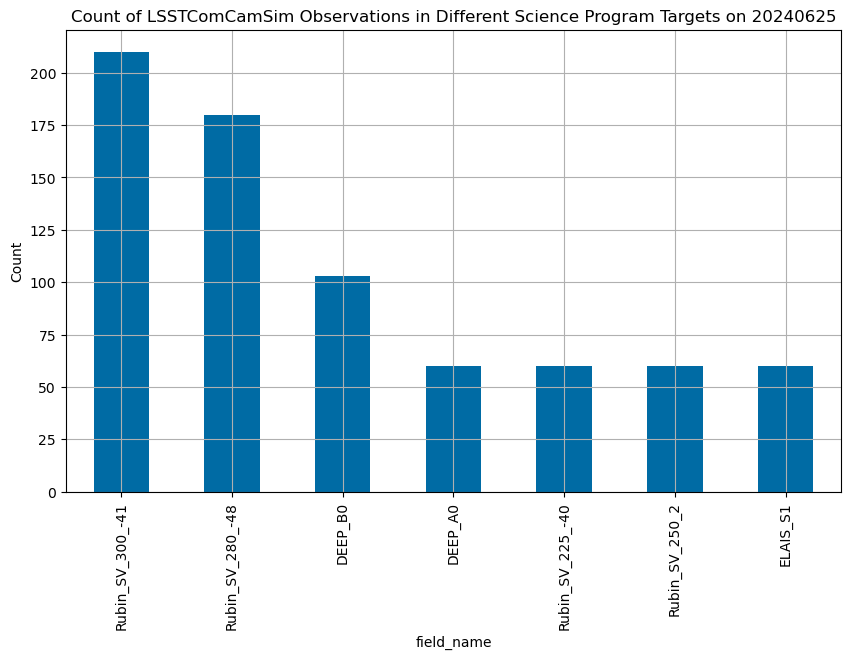

In [34]:
plt.figure(figsize=(10, 6))

# Count the occurrences of each unique value in col1
#value_counts = df_science['target'].value_counts()
value_counts = df_science[col_target].value_counts()

# Create the bar plot
value_counts.plot(kind='bar')

# Add labels and title
plt.xlabel(col_target)
plt.ylabel('Count')
title = """Count of %s Observations in Different Science Program Targets on %s""" %(instrument, day_obs)
plt.title(title)
plt.grid(True)


#### 3.2.4 Science Program and Target

Tabulate the counts of exposures for the different science programs and targets observed on this date:

In [35]:
df_science.groupby([col_sciprog,col_target]).count()[col_id]

science_program  field_name      
BLOCK-297        DEEP_A0              60
                 DEEP_B0             103
                 ELAIS_S1             60
                 Rubin_SV_225_-40     60
                 Rubin_SV_250_2       60
                 Rubin_SV_280_-48    180
                 Rubin_SV_300_-41    210
Name: id, dtype: int64

Convert results to a pandas DataFrame using the `df2Dgroupby` function defined in Section 1.2.    Ignore any targets with a count of 0 by setting `fill_zeros` parameter to `False`.

In [36]:
df_science_grouped = df2Dgroupby(df_science, col_sciprog, col_target, col_id, False)
df_science_grouped

,science_program,field_name,number
0,BLOCK-297,DEEP_A0,60
1,BLOCK-297,DEEP_B0,103
2,BLOCK-297,ELAIS_S1,60
3,BLOCK-297,Rubin_SV_225_-40,60
4,BLOCK-297,Rubin_SV_250_2,60
5,BLOCK-297,Rubin_SV_280_-48,180
6,BLOCK-297,Rubin_SV_300_-41,210


Plot results as an annotated heatmap:

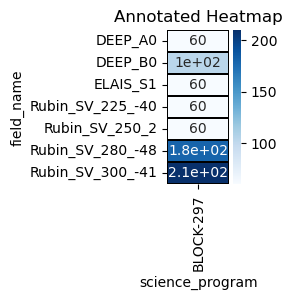

In [37]:
# First, we re-group df_science, setting the `fill_zeros` parameter back to `True`.  
#  This is mostly for aesthetic reasons for the plotting below (the value of '0' 
#  will be included in the annotations for those science_progam/target combos that
#  have no observations); otherwise those boxes will be left blank).
df_science_grouped = df2Dgroupby(df_science, col_sciprog, col_target, col_id, True)

# Now call the plotAnnotatedHeatMap_df2Dgroupby function defined in Section 1.2 above.
plotAnnotatedHeatMap_df2Dgroupby(df_science_grouped, col_target, col_sciprog, 'number', title='Annotated Heatmap', cmap='Blues')


#### 3.2.5 Target and Filter

Tabulate the counts of exposures for the different targets and filters observed on this date:

In [38]:
df_science.groupby([col_target,col_filter]).count()[col_id]

field_name        filter
DEEP_A0           g_01      20
                  i_06      20
                  r_03      20
DEEP_B0           g_01      40
                  i_06      23
                  r_03      40
ELAIS_S1          g_01      20
                  i_06      20
                  r_03      20
Rubin_SV_225_-40  g_01      20
                  i_06      20
                  r_03      20
Rubin_SV_250_2    g_01      20
                  i_06      20
                  r_03      20
Rubin_SV_280_-48  g_01      60
                  i_06      60
                  r_03      60
Rubin_SV_300_-41  g_01      70
                  i_06      80
                  r_03      60
Name: id, dtype: int64

Convert results into a pandas DataFrame:

In [39]:
df_science_grouped = df2Dgroupby(df_science, col_target, col_filter, col_id, False)
df_science_grouped

,field_name,filter,number
0,DEEP_A0,g_01,20
1,DEEP_A0,i_06,20
2,DEEP_A0,r_03,20
3,DEEP_B0,g_01,40
4,DEEP_B0,i_06,23
5,DEEP_B0,r_03,40
6,ELAIS_S1,g_01,20
7,ELAIS_S1,i_06,20
8,ELAIS_S1,r_03,20
9,Rubin_SV_225_-40,g_01,20


Plot results as an annotated heatmap:

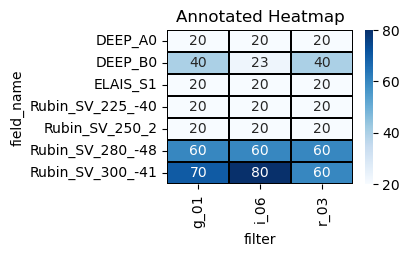

In [40]:
df_science_grouped = df2Dgroupby(df_science, col_target, col_filter, col_id, True)
plotAnnotatedHeatMap_df2Dgroupby(df_science_grouped, col_target, col_filter, 'number', title='Annotated Heatmap', cmap='Blues')

#### 3.2.6 Science Program, Target, and Filter

Tabulate the counts of exposures for the different science programs, targets, and filters observed on this date:

In [41]:
df_science.groupby([col_sciprog,col_target,col_filter]).count()[col_id]

science_program  field_name        filter
BLOCK-297        DEEP_A0           g_01      20
                                   i_06      20
                                   r_03      20
                 DEEP_B0           g_01      40
                                   i_06      23
                                   r_03      40
                 ELAIS_S1          g_01      20
                                   i_06      20
                                   r_03      20
                 Rubin_SV_225_-40  g_01      20
                                   i_06      20
                                   r_03      20
                 Rubin_SV_250_2    g_01      20
                                   i_06      20
                                   r_03      20
                 Rubin_SV_280_-48  g_01      60
                                   i_06      60
                                   r_03      60
                 Rubin_SV_300_-41  g_01      70
                                   i_06      8

Convert this result into a pandas DataFrame using the `df3groupby` function defined in Section 1.2 above and display the resulting table:

In [42]:
df_science_grouped = df3Dgroupby(df_science, col_sciprog, col_target, col_filter, col_id, False)
df_science_grouped

,science_program,field_name,filter,number
0,BLOCK-297,DEEP_A0,g_01,20
1,BLOCK-297,DEEP_A0,i_06,20
2,BLOCK-297,DEEP_A0,r_03,20
3,BLOCK-297,DEEP_B0,g_01,40
4,BLOCK-297,DEEP_B0,i_06,23
5,BLOCK-297,DEEP_B0,r_03,40
6,BLOCK-297,ELAIS_S1,g_01,20
7,BLOCK-297,ELAIS_S1,i_06,20
8,BLOCK-297,ELAIS_S1,r_03,20
9,BLOCK-297,Rubin_SV_225_-40,g_01,20


### 3.3 Positions

#### 3.3.1 Target RA, DEC

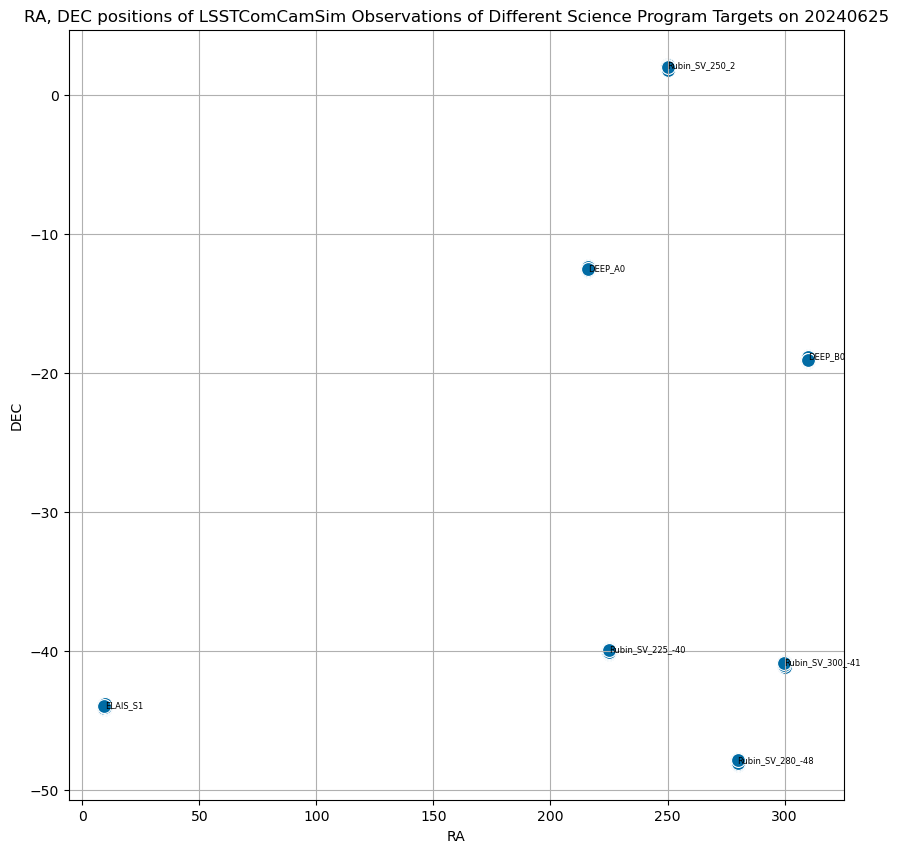

In [43]:
df_science.sort_values(by='field_name', inplace=True)

plt.figure(figsize=(10, 10))

# Plot in Cartesian coordinates
if df_science[col_target].dtype == "int64" or df_science[col_target].dtype == "float64":
    # We create and annotate the plot one way if col_target is numerical...
    ax = sns.scatterplot(data=df_science, x="ra", y="dec", hue=col_target, palette='viridis', s=100)
else:
    # Otherwise, if col_target is a string or similar, we create and annotate the plot this way...
    #  (This could be done better.  As it is, the spacing is very crowded.)
    ax = sns.scatterplot(data=df_science, x="ra", y="dec", s=100)
    prev_label = 'XXXXXX'
    for i, label in enumerate(df_science[col_target]):
        if label != prev_label:
            ax.annotate(label, (df_science['ra'].iloc[i], df_science['dec'].iloc[i]), fontsize=6)
            prev_label = label

# Add labels and title
plt.xlabel('RA')
plt.ylabel('DEC')
title = """RA, DEC positions of %s Observations of Different Science Program Targets on %s""" %(instrument, day_obs)
plt.title(title)
plt.grid(True)

#### 3.3.2 Target vs. zenith_angle

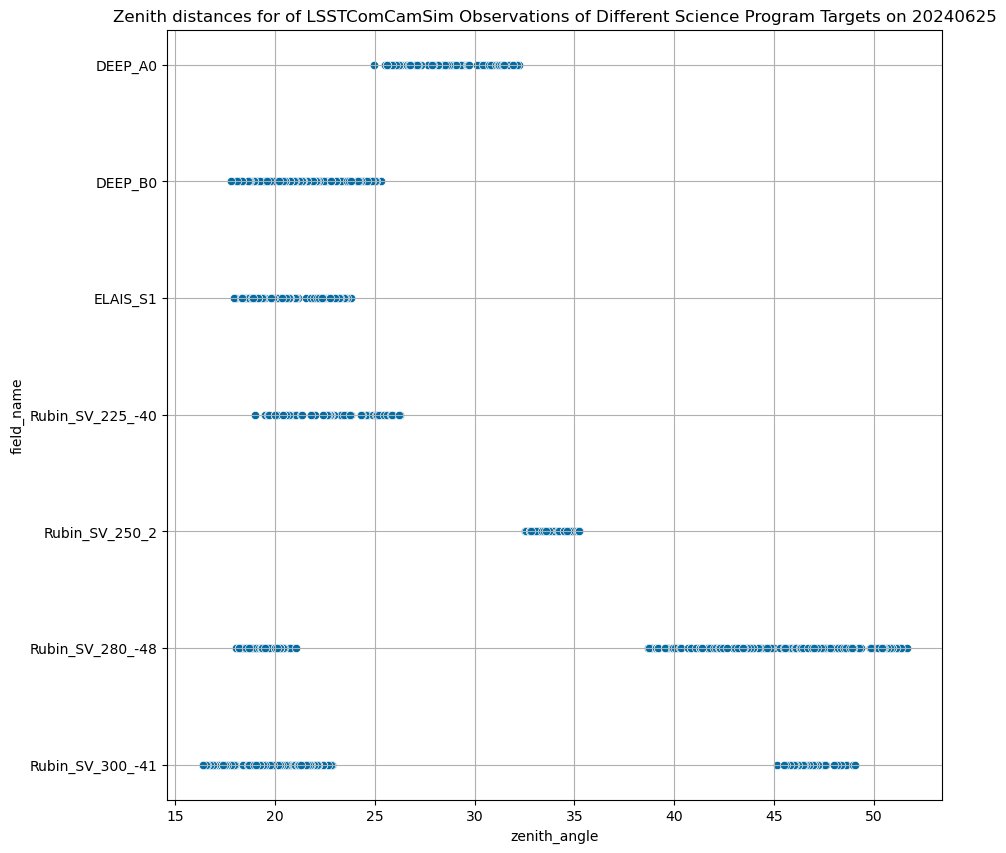

In [44]:
plt.figure(figsize=(10, 10))

ax = sns.scatterplot(data=df_science, x="zenith_angle", y=col_target)

# Add labels and title
#plt.xlabel('Zenith Angle')
#plt.ylabel('Target')
title = """Zenith distances for of %s Observations of Different Science Program Targets on %s""" %(instrument, day_obs)
plt.title(title)
plt.grid(True)


#### 3.3.3 Target vs. MJD

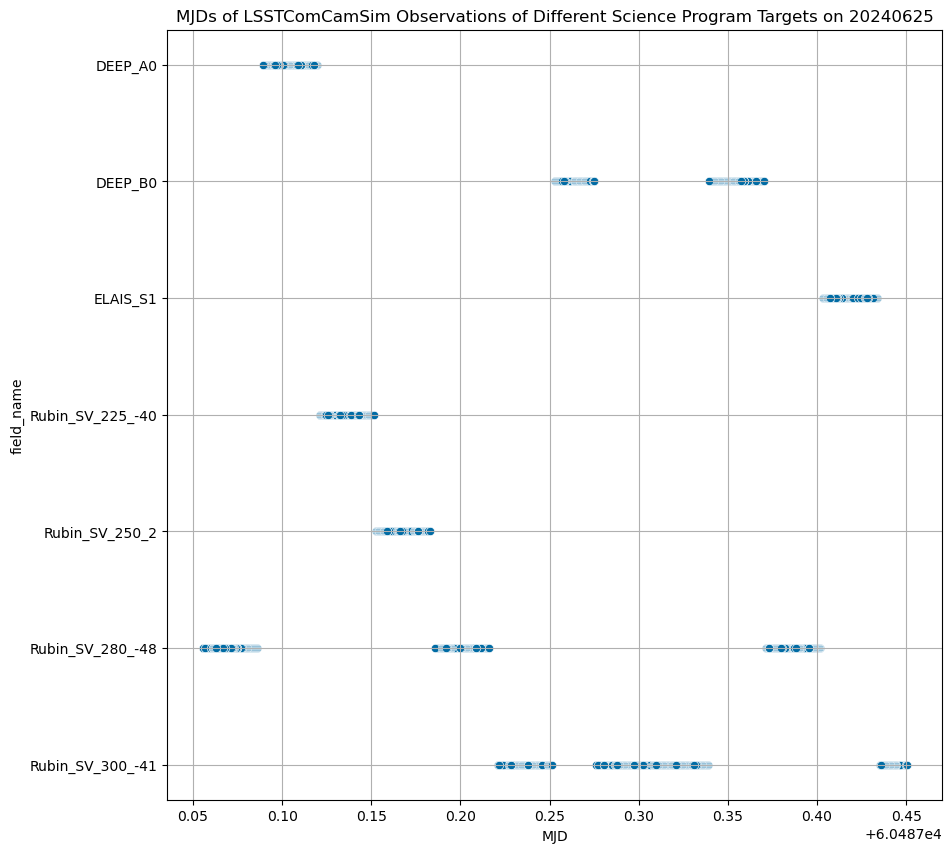

In [45]:
plt.figure(figsize=(10, 10))

#ax = sns.scatterplot(data=df_science, x="mjd", y="target")
ax = sns.scatterplot(data=df_science, x="mjd", y=col_target)


# Add labels and title
plt.xlabel('MJD')
plt.ylabel(col_target)
title = """MJDs of %s Observations of Different Science Program Targets on %s""" %(instrument, day_obs)
plt.title(title)
plt.grid(True)


#### 3.3.4 Target zenith angle vs. MJD

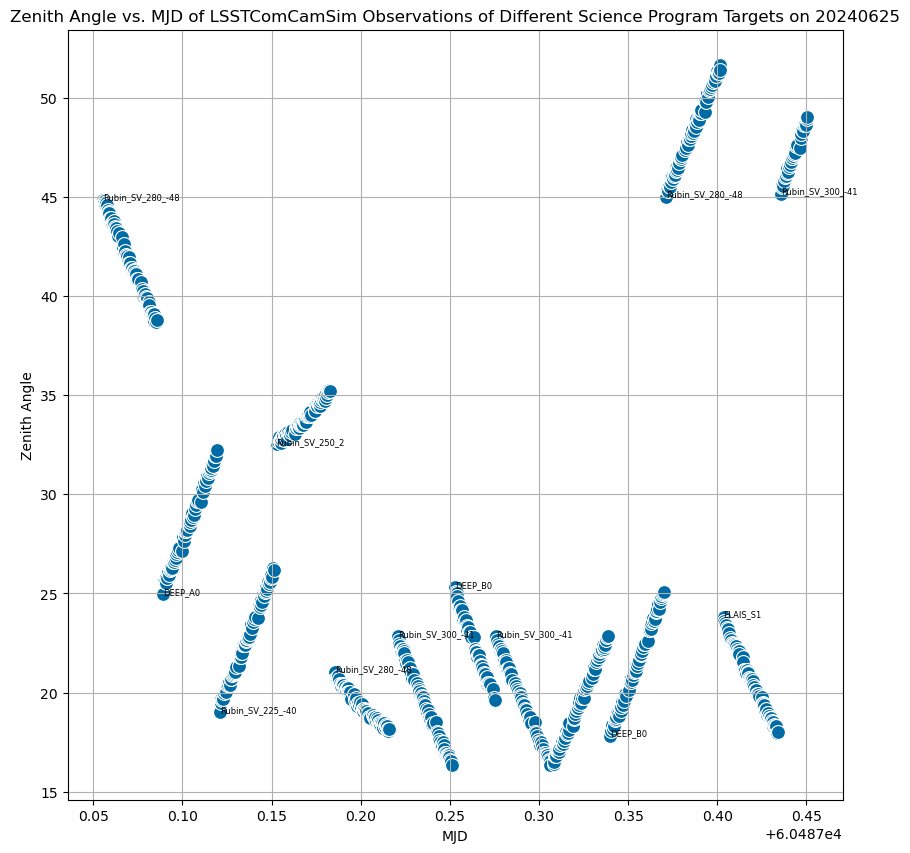

In [46]:
df_science.sort_values(by='mjd', inplace=True)

plt.figure(figsize=(10, 10))

# Plot in Cartesian coordinates
if df_science[col_target].dtype == "int64" or df_science[col_target].dtype == "float64":
    # We create and annotate the plot one way if col_target is numerical...
    ax = sns.scatterplot(data=df_science, x="mjd", y="zenith_angle", hue=col_target, palette='viridis', s=100)
else:
    # Otherwise, if col_target is a string or similar, we create and annotate the plot this way...
    #  (This could be done better.  As it is, the spacing is very crowded.)
    ax = sns.scatterplot(data=df_science, x="mjd", y="zenith_angle", s=100)
    prev_label = 'XXXXXX'
    for i, label in enumerate(df_science[col_target]):
        if label != prev_label:
            #mjd = df_science['mjd'].iloc[i]
            #za = df_science['zenith_angle'].iloc[i]
            #print(i, label, mjd, za)
            ax.annotate(label, (df_science['mjd'].iloc[i], df_science['zenith_angle'].iloc[i]), fontsize=6)
            prev_label = label

# Add labels and title
plt.xlabel('MJD')
plt.ylabel('Zenith Angle')
title = """Zenith Angle vs. MJD of %s Observations of Different Science Program Targets on %s""" %(instrument, day_obs)
plt.title(title)
plt.grid(True)

## 4. Final cleanup

Reset the pandas maximum rows option it its original default.

In [47]:
# Reset the display.max_rows option to the original default
pd.reset_option("display.max_rows")

In [48]:
# Stop automatic execution of cells before reaching the Sandbox...
#sys.exit("Notebook execution stopped here.")

raise StopExecution

## 5. Sandbox